In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/chest_x_ray

/content/drive/MyDrive/chest_x_ray


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
from tqdm import tqdm

In [4]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from PIL import Image
torch.cuda.empty_cache()

In [5]:
from nets import Generator, Discriminator
from losses import get_disc_loss, get_gen_loss
from dataset import UnpairedGenerationDataset

## Initialization

In [6]:
batch_size = 4
lr = 0.0002
device = 'cuda'

In [7]:
gen_AP_2_PA = Generator(1, 1).to(device)
gen_PA_2_AP = Generator(1, 1).to(device)
gen_opt = torch.optim.Adam(list(gen_AP_2_PA.parameters()) + list(gen_PA_2_AP.parameters()), lr=lr, betas=(0.5, 0.999))
disc_AP = Discriminator(1).to(device)
disc_AP_opt = torch.optim.Adam(disc_AP.parameters(), lr=lr, betas=(0.5, 0.999))
disc_PA = Discriminator(1).to(device)
disc_PA_opt = torch.optim.Adam(disc_PA.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

pretrained = False
if pretrained:
    pre_dict = torch.load('cycleGAN_1.pth')
    gen_AP_2_PA.load_state_dict(pre_dict['gen_AP_2_PA'])
    gen_PA_2_AP.load_state_dict(pre_dict['gen_PA_2_AP'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_AP.load_state_dict(pre_dict['disc_AP'])
    disc_AP_opt.load_state_dict(pre_dict['disc_AP_opt'])
    disc_PA.load_state_dict(pre_dict['disc_PA'])
    disc_PA_opt.load_state_dict(pre_dict['disc_PA_opt'])
else:
    gen_AP_2_PA = gen_AP_2_PA.apply(weights_init)
    gen_PA_2_AP = gen_PA_2_AP.apply(weights_init)
    disc_AP = disc_AP.apply(weights_init)
    disc_PA = disc_PA.apply(weights_init)

## Data loading

In [9]:
data = pd.read_csv('position.csv')

In [10]:
paths_ap = data.loc[data['position'] == 'AP', 'name'].values
paths_pa = data.loc[data['position'] == 'PA', 'name'].values

In [11]:
len(paths_ap), len(paths_pa)

(11910, 14204)

In [12]:
dataset = UnpairedGenerationDataset(paths_ap, paths_pa)

In [13]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Training

In [14]:
def show_tensor_images(real_ap, real_pa, fake_pa, fake_ap, size=(1, 256, 256)):
    f, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 6))
    view = ['AP', 'PA']

    for i, image_tensor, output_tensor in [(0, real_ap, fake_pa), (1, real_pa, fake_ap)]:
        image_tensor = image_tensor.detach().cpu().view(-1, *size)
        image_tensor = make_grid(image_tensor, nrow=8)
        axes[0][i].imshow(image_tensor.permute(1, 2, 0).squeeze())
        axes[0][i].set_title(f'Source {view[i]}')
        axes[0][i].axis('off')

        output_tensor = output_tensor.detach().cpu().view(-1, *size)
        output_tensor = make_grid(output_tensor, nrow=8)
        axes[1][i].imshow(output_tensor.permute(1, 2, 0).squeeze())
        axes[1][i].set_title(f'Generated {view[1 - i]}')
        axes[1][i].axis('off')
    plt.show()

In [15]:
adv_criterion = nn.MSELoss() 
recon_criterion = nn.L1Loss()

  0%|          | 0/2978 [00:00<?, ?it/s]

Epoch 0: Step 0:
Generator loss: 0.066492, Discriminator AP loss: 0.007440, Discriminator PA loss: 0.003778


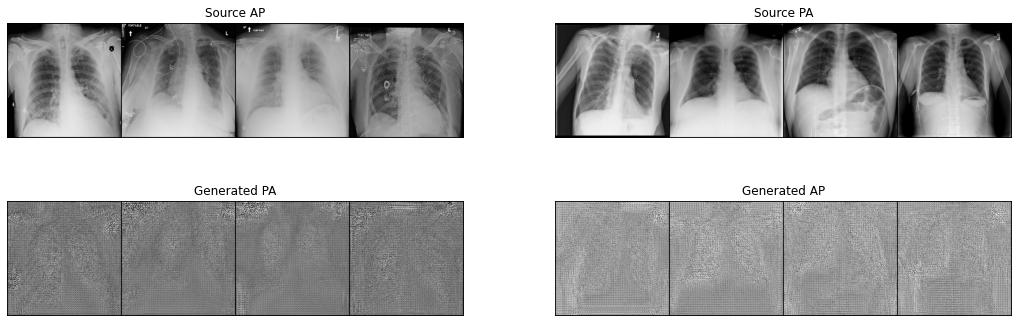

  3%|▎         | 100/2978 [13:38<6:21:10,  7.95s/it]

Epoch 0: Step 100:
Generator loss: 2.536246, Discriminator AP loss: 0.304455, Discriminator PA loss: 0.264779


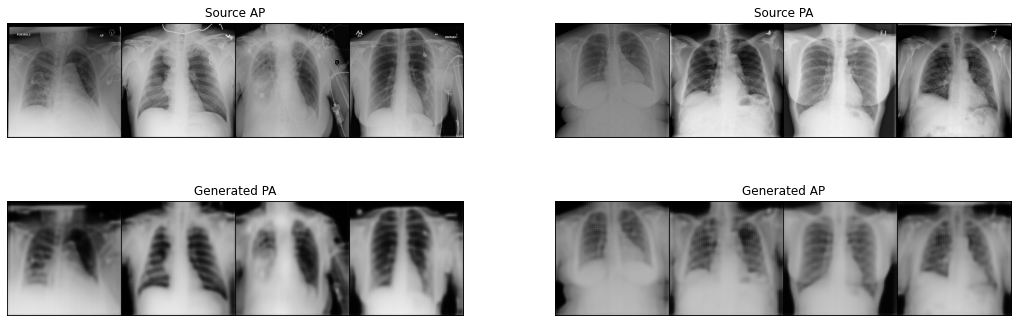

  7%|▋         | 200/2978 [26:59<6:10:56,  8.01s/it]

Epoch 0: Step 200:
Generator loss: 2.084237, Discriminator AP loss: 0.254229, Discriminator PA loss: 0.251763


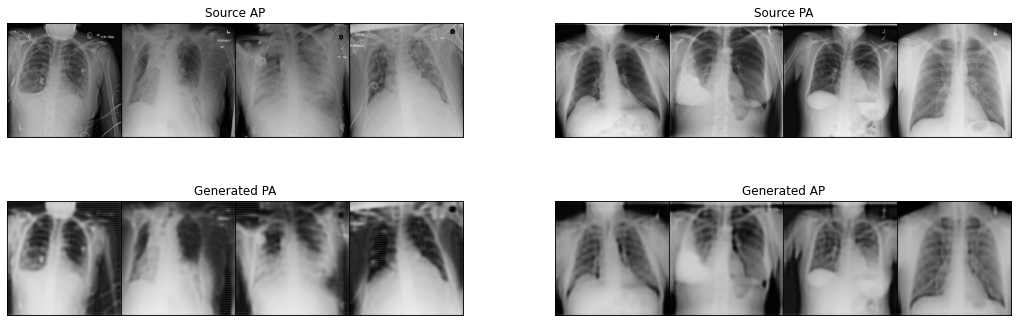

 10%|█         | 300/2978 [40:17<5:55:43,  7.97s/it]

Epoch 0: Step 300:
Generator loss: 2.068343, Discriminator AP loss: 0.252122, Discriminator PA loss: 0.247714


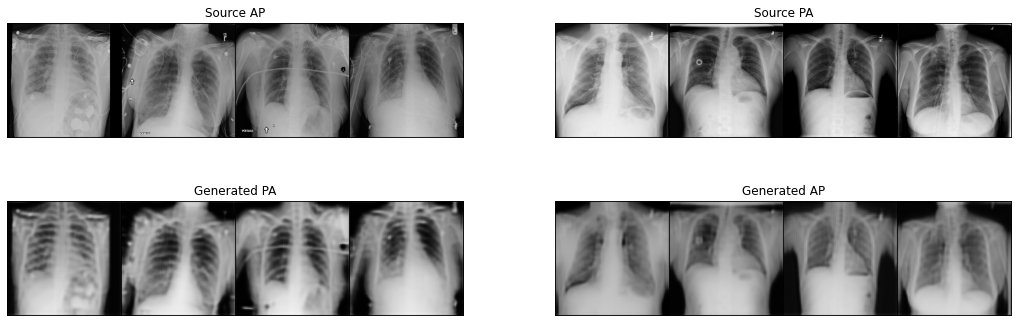

 13%|█▎        | 400/2978 [53:34<5:42:18,  7.97s/it]

Epoch 0: Step 400:
Generator loss: 1.943676, Discriminator AP loss: 0.248126, Discriminator PA loss: 0.246152


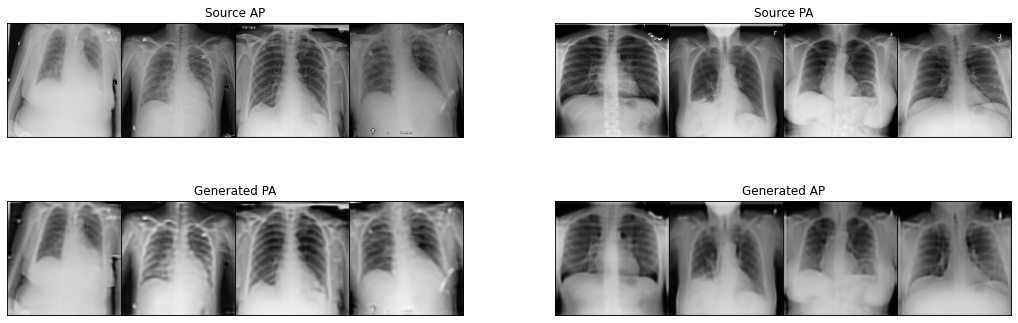

 17%|█▋        | 500/2978 [1:06:55<5:24:40,  7.86s/it]

Epoch 0: Step 500:
Generator loss: 1.906055, Discriminator AP loss: 0.246165, Discriminator PA loss: 0.247417


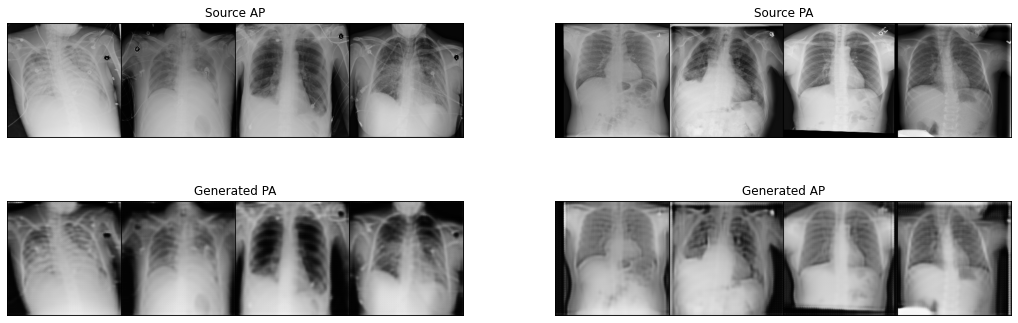

 20%|██        | 600/2978 [1:20:13<5:14:19,  7.93s/it]

Epoch 0: Step 600:
Generator loss: 1.953320, Discriminator AP loss: 0.248224, Discriminator PA loss: 0.244280


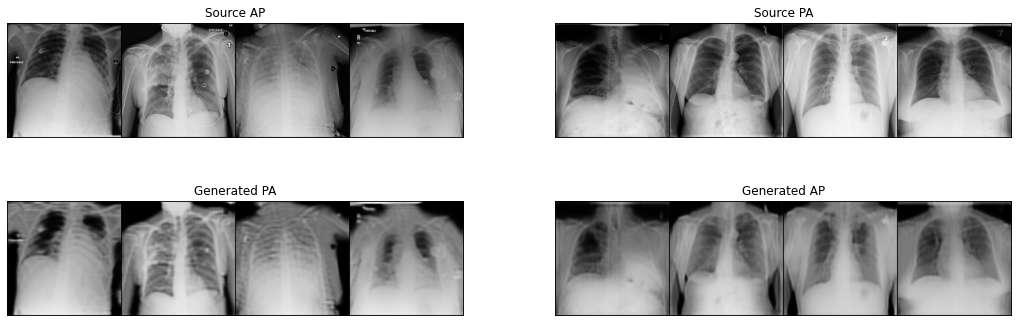

 24%|██▎       | 700/2978 [1:33:35<5:02:36,  7.97s/it]

Epoch 0: Step 700:
Generator loss: 1.821861, Discriminator AP loss: 0.249111, Discriminator PA loss: 0.249908


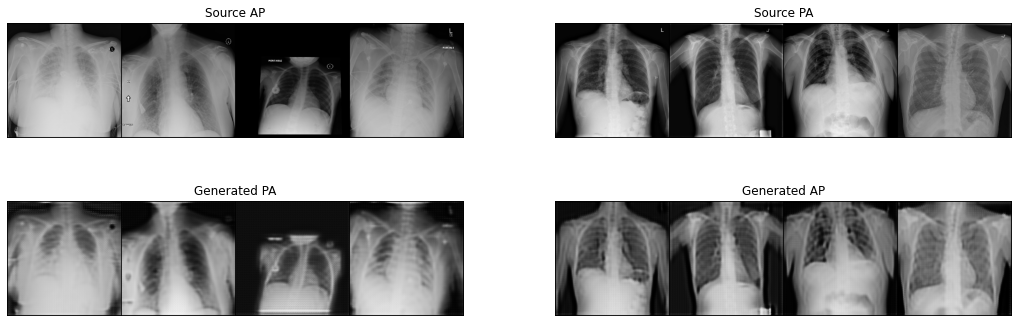

 27%|██▋       | 800/2978 [1:46:56<4:47:23,  7.92s/it]

Epoch 0: Step 800:
Generator loss: 1.833414, Discriminator AP loss: 0.244200, Discriminator PA loss: 0.243204


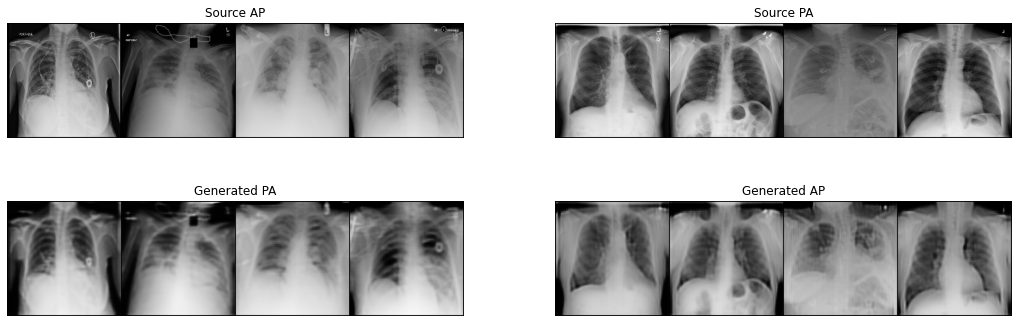

 30%|███       | 900/2978 [2:00:25<4:43:04,  8.17s/it]

Epoch 0: Step 900:
Generator loss: 1.787656, Discriminator AP loss: 0.240711, Discriminator PA loss: 0.239555


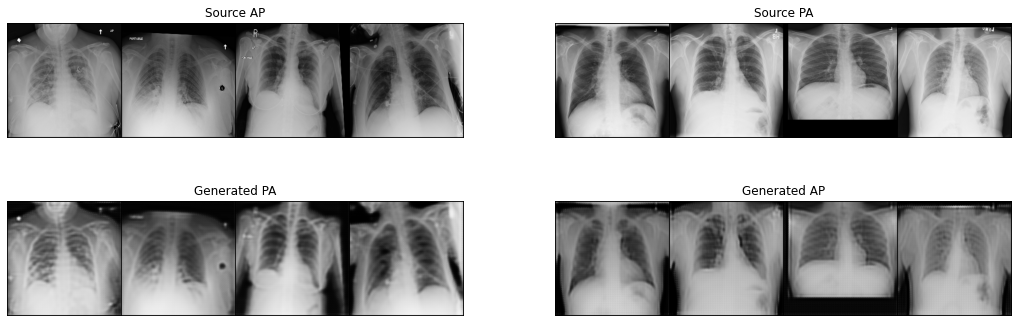

 34%|███▎      | 1000/2978 [2:13:52<4:29:47,  8.18s/it]

Epoch 0: Step 1000:
Generator loss: 1.711133, Discriminator AP loss: 0.238855, Discriminator PA loss: 0.234950


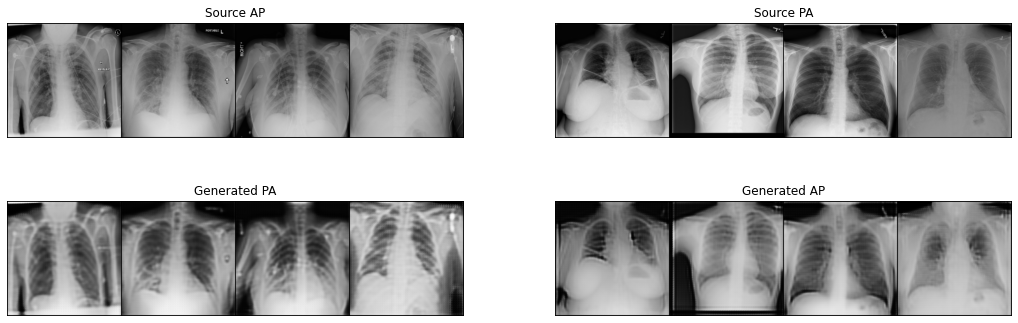

 37%|███▋      | 1100/2978 [2:27:21<4:10:31,  8.00s/it]

Epoch 0: Step 1100:
Generator loss: 1.736914, Discriminator AP loss: 0.231158, Discriminator PA loss: 0.231516


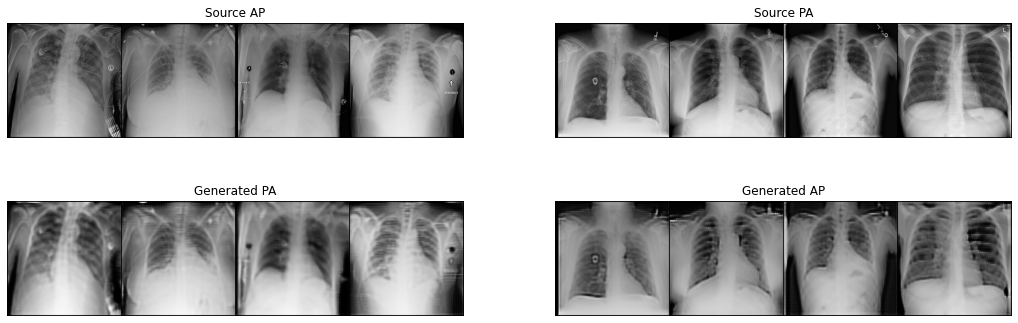

 40%|████      | 1200/2978 [2:40:47<3:58:23,  8.04s/it]

Epoch 0: Step 1200:
Generator loss: 1.762781, Discriminator AP loss: 0.233455, Discriminator PA loss: 0.228879


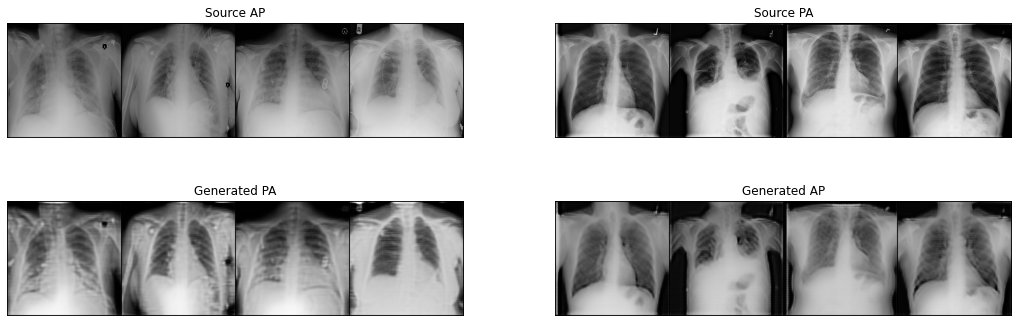

 44%|████▎     | 1300/2978 [2:54:08<3:45:48,  8.07s/it]

Epoch 0: Step 1300:
Generator loss: 1.802793, Discriminator AP loss: 0.226684, Discriminator PA loss: 0.222256


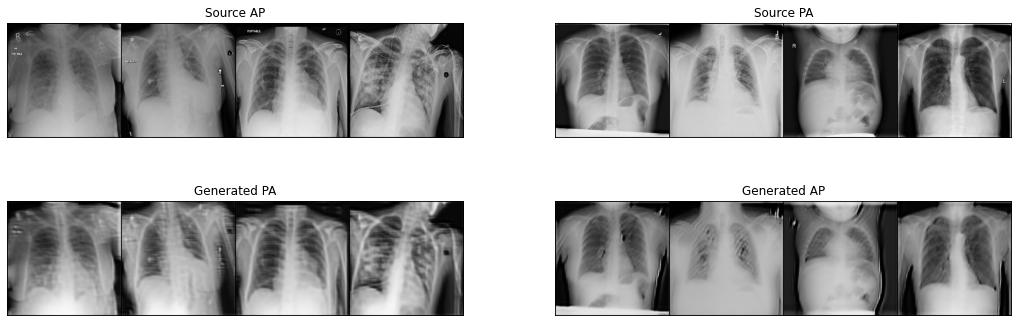

 47%|████▋     | 1400/2978 [3:07:35<3:34:55,  8.17s/it]

Epoch 0: Step 1400:
Generator loss: 1.726185, Discriminator AP loss: 0.240935, Discriminator PA loss: 0.230113


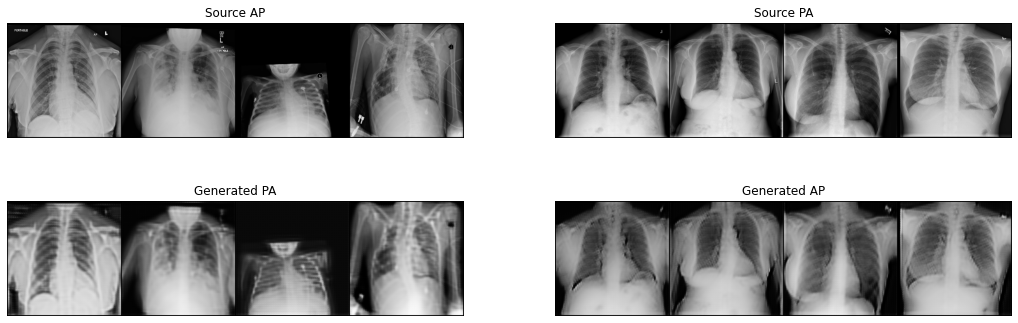

 50%|█████     | 1500/2978 [3:21:00<3:21:16,  8.17s/it]

Epoch 0: Step 1500:
Generator loss: 1.656795, Discriminator AP loss: 0.236110, Discriminator PA loss: 0.217824


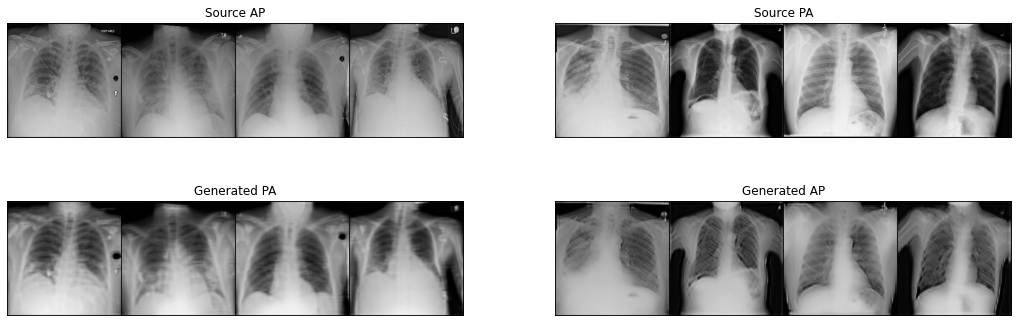

 53%|█████▎    | 1590/2978 [3:33:08<3:07:14,  8.09s/it]

In [ ]:
plot_generator_loss = []
plot_discriminator_ap_loss = []
plot_discriminator_pa_loss = []

mean_generator_loss = 0
mean_discriminator_ap_loss = 0
mean_discriminator_pa_loss = 0

n_epochs = 10
display_step = 100
cur_step = 0

for epoch in range(n_epochs):

    for real_ap, real_pa in tqdm(dataloader):

        real_ap = real_ap.to(device)
        real_pa = real_pa.to(device)

        # AP discriminator
        disc_AP_opt.zero_grad()
        with torch.no_grad():
            fake_ap = gen_PA_2_AP(real_pa)
        disc_AP_loss = get_disc_loss(real_ap, fake_ap, disc_AP, adv_criterion)
        disc_AP_loss.backward(retain_graph=True)
        disc_AP_opt.step()

        # PA discriminator
        disc_PA_opt.zero_grad()
        with torch.no_grad():
            fake_pa = gen_AP_2_PA(real_ap)
        disc_PA_loss = get_disc_loss(real_pa, fake_pa, disc_PA, adv_criterion)
        disc_PA_loss.backward(retain_graph=True)
        disc_PA_opt.step()

        # Generators
        gen_opt.zero_grad()
        gen_loss, fake_A, fake_B = get_gen_loss(
            real_ap, real_pa, gen_AP_2_PA, gen_PA_2_AP, disc_AP, disc_PA, adv_criterion, recon_criterion, recon_criterion
        )
        gen_loss.backward()
        gen_opt.step()

        # Track losses
        mean_discriminator_ap_loss += disc_AP_loss.item() / display_step
        mean_discriminator_pa_loss += disc_PA_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0:
            print(f"Epoch {epoch}: Step {cur_step}:")
            print(f"Generator loss: {mean_generator_loss :0.6f}, Discriminator AP loss: {mean_discriminator_ap_loss :0.6f}, Discriminator PA loss: {mean_discriminator_pa_loss :0.6f}")
            show_tensor_images(real_ap, real_pa, fake_pa, fake_ap)
            mean_generator_loss = 0
            mean_discriminator_ap_loss = 0
            mean_discriminator_pa_loss = 0

            plot_generator_loss.append(mean_generator_loss)
            plot_discriminator_ap_loss.append(mean_discriminator_ap_loss)
            plot_discriminator_pa_loss.append(mean_discriminator_pa_loss)
        cur_step += 1
    
    torch.save({
        'gen_AP_2_PA': gen_AP_2_PA.state_dict(),
        'gen_PA_2_AP': gen_PA_2_AP.state_dict(),
        'gen_opt': gen_opt.state_dict(),
        'disc_AP': disc_AP.state_dict(),
        'disc_AP_opt': disc_AP_opt.state_dict(),
        'disc_PA': disc_PA.state_dict(),
        'disc_PA_opt': disc_PA_opt.state_dict()
    }, f"weigth/cycleGAN_{epoch + 1}.pth")


In [ ]:
plt.plot(plot_generator_loss, label='generator loss')
plt.plot(plot_discriminator_ap_loss, label='discriminator AP loss')
plt.plot(plot_discriminator_pa_loss, label='discriminator PA loss')
plt.legend()
plt.plot()

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
f.set_figheight(6)
f.set_figwidth(20)

ax1.plot(plot_generator_loss)
ax1.plot(np.zeros_like(plot_generator_loss), '--')
ax1.set_title('Generator loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch number')

ax2.plot(plot_discriminator_ap_loss, label='discriminator AP loss')
ax2.plot(plot_discriminator_pa_loss, label='discriminator PA loss')
ax2.plot(np.zeros_like(plot_discriminator_loss), '--')
ax2.set_legend()
ax2.set_title('Discriminators\' losses')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch number')

plt.show()